<a href="https://colab.research.google.com/github/AmrMKayid/FaceGAN/blob/master/InterFaceGAN-exps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.executable

'/usr/bin/python3'

In [ ]:
%tensorflow_version 1.x

In [5]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
print(tf.__version__)

from PIL import Image

%matplotlib inline

1.15.2


In [ ]:
%cd ~/FaceGAN/stylegan-encoder
!ls

/home/ubuntu/FaceGAN/stylegan-encoder
LICENSE.txt			       latent_vectors
Learn_direction_in_latent_space.ipynb  masks
Play_with_latent_directions.ipynb      metrics
README.md			       mona_example.jpg
StyleGAN_Encoder_Tutorial.ipynb        old_24-6_exps
__pycache__			       old_exps
adaptive.py			       out.txt
align_images.py			       output.txt
aligned_images			       output_vectors.npy
all_aligned_images		       pretrained_example.py
cache				       raw_images
config.py			       requirements.txt
data				       robust_loss
dataset_tool.py			       run_metrics.py
dnnlib				       swa.py
encode_images.py		       teaser.png
encoder				       train.py
exps				       train_effnet.py
ffhq_dataset			       train_resnet.py
generate_figures.py		       training
generated_images		       videos
latent_representations


In [ ]:
#@title `loading StyleGAN network into memory`

import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()

synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, 
                                              nchw_to_nhwc=True),
                        minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
    generator_network, discriminator_network, averaged_generator_network = pickle.load(f)

print("StyleGAN loaded & ready for sampling!")

Loading StyleGAN model from cache/60362027561e3cdd18da081cf8f58c2c_karras2019stylegan-ffhq-1024x1024.pkl...
StyleGAN loaded & ready for sampling!


In [ ]:
#@title `images viz utils`

def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), 
                             None, 
                             randomize_noise=False, 
                             **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), 
                                                  randomize_noise=False, 
                                                  **synthesis_kwargs)

def plot_imgs(model, rows, columns):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      img = generate_images(model, np.random.randn(1,512), z = True)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

In [ ]:
!pwd

/home/ubuntu/FaceGAN/stylegan-encoder


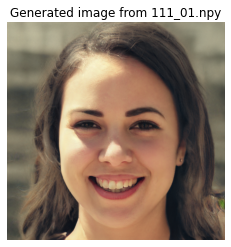

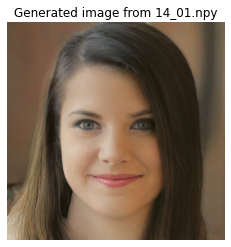

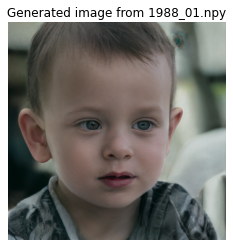

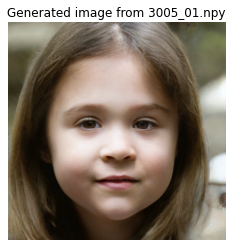

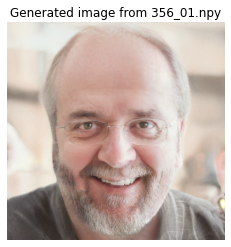

In [ ]:
#@title `Results of Encoding`

EXP_PATH = '/home/ubuntu/FaceGAN/stylegan-encoder/exps-interface/exp4/latent_representations/'

for f in sorted(os.listdir(EXP_PATH)):
  w = np.load(EXP_PATH + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  plt.show()

In [4]:
!unzip exp4.zip

Archive:  exp4.zip
   creating: exp4/
   creating: exp4/latent_vectors/
   creating: exp4/latent_representations/
  inflating: exp4/latent_vectors/output_vectors.npy  
  inflating: exp4/latent_representations/3005_01.npy  
  inflating: exp4/latent_representations/111_01.npy  
  inflating: exp4/latent_representations/1988_01.npy  
  inflating: exp4/latent_representations/356_01.npy  
  inflating: exp4/latent_representations/14_01.npy  


In [46]:
EXP_PATH = '/content/exp4/latent_representations/'

In [47]:
#@title `Cherry pick images & dump latent vectors to disk`

good_images = [i for i in range(len(os.listdir(EXP_PATH)))] # encoded images numbers

latents = sorted(os.listdir(EXP_PATH))

os.makedirs(str(pathlib.Path(EXP_PATH).parent) + '/latent_vectors/', exist_ok=True)
out_file = str(pathlib.Path(EXP_PATH).parent) + '/latent_vectors/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load(EXP_PATH + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s \nsaved to %s!" %(len(good_images), str(w.shape), out_file))

5 latent vectors of shape (18, 512) 
saved to /content/exp4/latent_vectors/output_vectors.npy!


In [48]:
final_w_vectors.shape

(5, 18, 512)

# Manipulating the faces

In [49]:
#@title `Cloning InterFaceGAN`
# %cd ~/FaceGAN
# !git clone https://github.com/AmrMKayid/interfacegan
%cd /content/interfacegan

/content/interfacegan


In [50]:
#@title `Download the pretrained StyleGAN FFHQ network from NVIDIA`
# !gdown https://drive.google.com/uc?id=1o4zmXaHtd_oNL754NsXNWi9wYOlAPTC3
# !mv karras2019stylegan-ffhq-1024x1024.pkl /content/interfacegan/models/pretrain/karras2019stylegan-ffhq-1024x1024.pkl

In [51]:
out_file

'/content/exp4/latent_vectors/output_vectors.npy'

In [52]:
#@title `Load Our custom latent space vectors`

final_w_vectors = np.load(out_file)

print("%d latent vectors of shape %s loaded from %s!" %(final_w_vectors.shape[0], 
                                                        str(final_w_vectors.shape[1:]), 
                                                        'output_vectors.npy'))

5 latent vectors of shape (18, 512) loaded from output_vectors.npy!


In [53]:
#@title `Latent Space Configs`

latent_direction = 'age'      #@param ['age', 'eyeglasses', 'gender', 'pose', 'smile'] {allow-input: true}

# Controls how strongly we push the face into a certain latent direction (try 1-5)
morph_strength = 3           #@param {type:"slider", min:0, max:5, step:1} 

# The amount of intermediate steps/frames to render along the interpolation path
nr_interpolation_steps = 50  #@param {type:"slider", min:0, max:100, step:1} 

In [54]:
#@title `Selected Configs`
boundary_file = 'stylegan_ffhq_%s_w_boundary.npy' %latent_direction

print("Ready to start manipulating faces in the ** %s ** direction!" %latent_direction)
print("Interpolation from %d to %d with %d intermediate frames." %(-morph_strength, morph_strength, nr_interpolation_steps))
print("\nLoading latent directions from %s" %boundary_file)

Ready to start manipulating faces in the ** age ** direction!
Interpolation from -3 to 3 with 50 intermediate frames.

Loading latent directions from stylegan_ffhq_age_w_boundary.npy


In [55]:
#@title `Running latent interpolations`

!rm -rf results 2> /dev/null 
!python edit.py -m stylegan_ffhq \
               -b "boundaries/{boundary_file}" \
               -s Wp \
               -i "{out_file}" \
               -o "results/{latent_direction}" \
               --start_distance "{-morph_strength}" \
               --end_distance "{morph_strength}" \
               --steps="{nr_interpolation_steps}"
               

[2020-06-28 14:26:29,632][INFO] Initializing generator.
[2020-06-28 14:26:29,905][INFO] Loading pytorch model from `models/pretrain/stylegan_ffhq.pth`.
[2020-06-28 14:26:30,191][INFO] Successfully loaded!
[2020-06-28 14:26:30,192][INFO]   `lod` of the loaded model is 0.0.
[2020-06-28 14:26:33,381][INFO] Preparing boundary.
[2020-06-28 14:26:33,382][INFO] Preparing latent codes.
[2020-06-28 14:26:33,382][INFO]   Load latent codes from `/content/exp4/latent_vectors/output_vectors.npy`.
[2020-06-28 14:26:33,383][INFO] Editing 5 samples.
[2020-06-28 14:27:01,973][INFO] Successfully edited 5 samples.


In [56]:
#@title `Results into movies`

image_folder = '/content/interfacegan/results/%s' %latent_direction
video_fps = 12.

from moviepy.editor import *
import cv2

out_path = '/content/output_videos/'

images = [img_path for img_path in sorted(os.listdir(image_folder)) if '.jpg' in img_path]
os.makedirs(out_path, exist_ok=True)

prev_id = None
img_sets = []
for img_path in images:
  img_id = img_path.split('_')[0]
  if img_id == prev_id: #append
    img_sets[-1].append(img_path)
    
  else: #start a new img set
    img_sets.append([])
    img_sets[-1].append(img_path)
  prev_id = img_id

print("Found %d image sets!\n" %len(img_sets))
if image_folder[-1] != '/':
  image_folder += '/'

def make_video(images, vid_name):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(vid_name, fourcc, video_fps, (1024, 1024))
    gen = {}
    for img in images:
      video.write(img)
    video.release()
    print('finished '+ vid_name)
    
    
for i in range(len(img_sets)):
  print("############################")
  print("\nGenerating video %d..." %i)
  set_images = []
  vid_name = out_path + 'out_video_%s_%02d.mp4' %(latent_direction,i)
  for img_path in img_sets[i]:
    set_images.append(cv2.imread(image_folder + img_path))

  set_images.extend(reversed(set_images))
  make_video(set_images, vid_name)

Found 5 image sets!

############################

Generating video 0...
finished /content/output_videos/out_video_age_00.mp4
############################

Generating video 1...
finished /content/output_videos/out_video_age_01.mp4
############################

Generating video 2...
finished /content/output_videos/out_video_age_02.mp4
############################

Generating video 3...
finished /content/output_videos/out_video_age_03.mp4
############################

Generating video 4...
finished /content/output_videos/out_video_age_04.mp4


In [60]:
#@title `Visualise resulting videos inside Notebook`

video_file_to_show = 3 #@param {type:"slider", min:0, max:5, step:1} 

clip = VideoFileClip(
    '/content/output_videos/out_video_%s_%02d.mp4' %
    (latent_direction, video_file_to_show),)
clip.ipython_display(
    height=512,
    autoplay=1,
    loop=1,
)

100%|██████████| 100/100 [00:01<00:00, 51.86it/s]


In [62]:
!zip -r /content/out_vids.zip /content/output_videos

  adding: content/output_videos/ (stored 0%)
  adding: content/output_videos/old_out_video_age_00.mp4 (deflated 3%)
  adding: content/output_videos/.ipynb_checkpoints/ (stored 0%)
  adding: content/output_videos/out_video_age_00.mp4 (deflated 0%)
  adding: content/output_videos/out_video_age_04.mp4 (deflated 0%)
  adding: content/output_videos/out_video_age_02.mp4 (deflated 0%)
  adding: content/output_videos/out_video_smile_00.mp4 (deflated 1%)
  adding: content/output_videos/out_video_age_01.mp4 (deflated 0%)
  adding: content/output_videos/out_video_age_03.mp4 (deflated 0%)
